# Chapter 4 Adaptive Time Step Methods

*Editor: Weipeng Xu*

*Last modified: 20/06/2025*

*Reference: Sundnes, Joakim. Solving Ordinary Differential Equations in Python. Springer Nature, 2024.*

To achieve a desired accuracy with the minimum computational effort, **adaptive methods** or **methods with automatic time step control** can be used to find the largest possible value of the time step $\Delta t$, which can adopt larger time steps in smooth regions and smaller time steps in regions with rapid variations.

## Choosing the Time Step Based on the Local Error

Although the global error analysis can be useful for selecting the time step, the adaptive time step methods are based on estimating the **local error** for each time step. We require the local error for a given step $e_n$ satisfies that
$$
e_n < \text{tol}
$$
for all steps. For a method of global order $p$, the local error is of order $p+1$:
$$
\begin{aligned}
    &e_n \approx C(\Delta t_n)^{p+1}\\
    &e_{n+1} \approx C(\Delta t_{p+1})^{p+1}
\end{aligned}
$$
where we assume that the error constant $C$ remains constant. Using the local error at step $n$, we have:
$$
C = \frac{e_n}{(\Delta t_n)^{p+1}}
$$
which is then inserted into $e_{n+1}$:
$$
e_{n+1} \approx \frac{e_n}{(\Delta t_n)^{p+1}}(\Delta t_{p+1})^{p+1}
$$
To achieve $e_{n+1}\approx\text{tol}$, we set
$$
\text{tol} = e_{n+1} = \frac{e_n}{(\Delta t_n)^{p+1}}(\Delta t_{p+1})^{p+1}
$$
Then we have:
$$
\Delta t_{p+1} = \eta(\frac{\text{tol}}{e_n}\Delta t_n^{p+1})^{\frac{1}{p+1}}
$$
where $\eta$ is an added safety factor. We see that the step size can be adjusted with the above formula according to the relationship between $e_{n}$ and $\text{tol}$.

## Estimating the Local Error

In general, direct computation of the error is not feasible as the analytical solution of the ODE is not available. However, we can estimate it by comparing two numerical solutions of different accuracy $\vert\hat{u}_n-u_n\vert$, where $\hat{u}$ is a more accurate solution.

Two methods can be adopted to compute $\hat{u}$:
* **Step doubling**: same nuemrical method but with more internal time steps to obatin $\hat{u}_{n+1}$
* **Embedded methods**: use another high order method to obtain $\hat{u}_{n+1}$

Since the embedded method requires very little additional computation, we will focus our discussion on it in this section.

For the embedded methods, since $\Delta t$ is small, we have $\Delta t^{p+1}\ll\Delta t^p$, we can directly the error as:
$$
e_n \approx C(\Delta t_n)^{p+1} \approx \vert\hat{u}_n-u_n\vert
$$
Instead of computing these two solutions using two entirely different methods, embeded methods use **the same stage computations** as the original method. An RK method with an embeded method for error estimation is often referred to as an **RK pair** of order $n(m)$ with original order $n$ and embeded order $m$. The corresponding Butcher tableaus can be expressed as:
$$
\begin{array}{c|cccccc}
c_1 & a_{11} & \cdots & a_{1s} \\
\vdots & \vdots &  & \vdots \\
c_s & a_{s1} & \cdots & a_{ss} \\
\hline
 & b_1 &  \cdots & b_s \\
 & \hat{b}_1 & \cdots & \hat{b}_s\\
\end{array}
$$
where $\hat{b}$ is a separate set of weights to compute $\hat{u}$. For some special RK pairs, additional stages may be introduced. The simplest possible emebeded RK pair is obatined by combining Heun's method (2-order) with the forward Euler method (1-order):

$$
\begin{array}{c|cc}
0   & 0 & 0 \\
1   & 1 & 0 \\
\hline
 & 1 & 0  \\
 & \frac{1}{2} & \frac{1}{2}  \\
\end{array}
$$


## Implementing an Adaptive Solver

In [19]:
from math import isnan, isinf
import numpy as onp
from scipy.optimize import root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class ODESolver:

    def __init__(self,f):
        self.model = f
        self.f = lambda t,u: onp.asarray(f(t,u), dtype=float)

    def set_initial_condition(self, u0):
        self.u0 = onp.asarray(u0, dtype=float)
        self.neq = len(u0)

    def solve(self, t_span, N):
        t0, T = t_span
        self.dt = (T-t0)/N
        self.t = onp.zeros((N+1, 1))
        self.u = onp.zeros((N+1, self.u0.size))

        msg = "Please set initial condition before calling solve"
        assert hasattr(self, "u0"), msg

        self.t[0] = t0
        self.u[0] = self.u0

        for n in range(N):
            self.n = n
            self.t[n+1] = self.t[n] + self.dt
            self.u[n+1] = self.advance()
        
        return self.t, self.u
    
    def advance(self):
        raise NotImplementedError("Advance method is not implemented in the based class")


class ImplicitRK(ODESolver):
    def solve_stages(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        s = self.stages
        k0 = f(t[n], u[n])
        k0 = onp.tile(k0, s)

        sol = root(self.stage_eq, k0)

        return onp.split(sol.x, s)
    
    def stage_eq(self, k_all):
        a, c = self.a, self.c
        s, neq = self.stages, self.neq

        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt

        res = onp.zeros_like(k_all)
        k = onp.split(k_all, s)
        for i in range(s):
            fi = f(t[n] + c[i] * dt, u[n] + dt *
                   sum([a[i, j] * k[j] for j in range(s)]))
            res[i * neq:(i+1) * neq] = k[i] - fi
        
        return res
    
    def advance(self):
        b = self.b
        u, n, t = self.u, self.n, self.t
        dt = self.dt
        k = self.solve_stages()
        return u[n] + dt * sum(b_ * k_ for b_, k_ in zip(b, k))

class SDIRK(ImplicitRK):
    def stage_eq(self, k, c_i, k_sum):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        gamma = self.gamma
        return k - f(t[n] + c_i * dt, u[n] + dt * (k_sum + gamma * k))
    
    def solve_stages(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        a, c = self.a, self.c
        s = self.stages

        k = f(t[n], u[n]) # initial guess for the first stage
        k_sum = onp.zeros_like(k)
        k_all = []
        for i in range(s):
            k_sum = sum(a_ * k_ for a_, k_ in zip(a[i, :i], k_all))
            k = root(self.stage_eq, k, args=(c[i], k_sum)).x
            k_all.append(k)
        
        return k_all


class ESDIRK(SDIRK):
    def solve_stages(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        a, c = self.a, self.c
        s = self.stages

        k = f(t[n], u[n]) 
        k_sum = onp.zeros_like(k)
        k_all = [k]
        for i in range(1, s):
            k_sum = sum(a_ * k_ for a_, k_ in zip(a[i, :i], k_all))
            k = root(self.stage_eq, k, args=(c[i], k_sum)).x
            k_all.append(k)
    
        return k_all

In [20]:
class AdaptiveODESolver(ODESolver):
    def __init__(self, f, eta=0.9):
        super().__init__(f)
        self.eta = eta
    
    def new_step_size(self, dt, loc_error):
        eta = self.eta
        tol = self.tol
        p = self.order
        if isnan(loc_error) or isinf(loc_error):
            """explicit methods may diverge for very stiff problems"""
            return self.min_dt
        
        new_dt = eta * (tol / loc_error)**(1 / (p+1)) * dt
        new_dt = max(new_dt, self.min_dt)
        return min(new_dt, self.max_dt)

    def solve(self, t_span, tol=1e-3, max_dt=onp.inf, min_dt=1e-5):
        t0, T = t_span
        self.tol = tol
        self.min_dt = min_dt
        self.max_dt = max_dt
        self.t = [t0]

        self.u = [self.u0]

        self.n = 0
        self.dt = 0.1 / onp.linalg.norm(self.f(t0, self.u0))

        loc_t = t0
        while loc_t < T:
            u_new, loc_error = self.advance()
            if loc_error < tol or self.dt < self.min_dt:
                loc_t += self.dt
                self.t.append(loc_t)
                self.u.append(u_new)
                self.dt = self.new_step_size(self.dt, loc_error)
                self.dt = min(self.dt, T - loc_t, max_dt)
                self.n += 1
            else:
                self.dt = self.new_step_size(self.dt, loc_error)
        return onp.array(self.t), onp.array(self.u)

An implementation of the Euler-Heun method pair can be written as:

In [21]:
class EulerHeun(AdaptiveODESolver):
    def __init__(self, f, eta=0.9):
        super().__init__(f, eta)
        self.order = 1

    def advance(self):
        u, f, t = self.u, self.f, self.t
        dt = self.dt
        k1 = f(t[-1], u[-1])
        k2 = f(t[-1] + dt, u[-1] + dt * k1)
        high = dt / 2 * (k1 + k2)
        low = dt * k1
        unew = u[-1] + low
        error = onp.linalg.norm(high - low)
        return unew, error

## More Advanced Embedded RK Methods

There are numerous explicit RK pairs of higher order than Euler-Heun 1(2) pair, such as **Fehlberg 4(5)** (**RKF45**) method:
$$
\begin{array}{r|ccccc}
0 & & & & \\ 
\frac{1}{4} & \frac{1}{4} & & & \\ 
\frac{3}{8} & \frac{3}{32} & \frac{9}{32} & & \\ 
\frac{12}{13} & \frac{1932}{2197} & -\frac{7200}{2197} & \frac{7296}{2197} & \\ 
1 & \frac{439}{216} & -8 & \frac{3680}{513} & -\frac{845}{4104} \\ 
\frac{1}{2} & -\frac{8}{27} & 2 & -\frac{3544}{2565} & \frac{1859}{4104} & -\frac{11}{40}\\
\hline
 & \frac{25}{216} & 0 & \frac{1408}{2565} & \frac{2197}{4104}  & -\frac{1}{5} & 0\\
  & \frac{16}{135} & 0 & \frac{6656}{12825} & \frac{28561}{56430}  & -\frac{9}{50} & \frac{2}{55}\\
\end{array}
$$
which implementation is as follows:

In [22]:
class RKF45(AdaptiveODESolver):
    
    def __init__(self, f, eta=0.9):
        super().__init__(f, eta)
        self.order = 4
    
    def advance(self):
        u, f, t = self.u, self.f, self.t
        dt = self.dt
        
        # Butcher tableau
        c2 = 1/4;   a21 = 1/4
        c3 = 3/8;   a31 = 3/32;      a32 = 9/32
        c4 = 12/13; a41 = 1932/2197; a42 = -7200/2197; a43 = 7296/2197
        c5 = 1;     a51 = 439/216;   a52 = -8;         a53 = 3680/513;   a54 = -845/4104
        c6 = 1/2;   a61 = -8/27;     a62 = 2;      a63 = -3544/2565; a64 = 1859/4104; a65 = -11/40
        b1 = 25/216;  b2 = 0;  b3 = 1408/2565;   b4 = 2197/4104;    b5 = -1/5; b6 = 0
        bh1 = 16/135; bh2 = 0; bh3 = 6656/12825; bh4 = 28561/56430; bh5 = -9/50; bh6 = 2/55 

        k1 = f(t[-1], u[-1])
        k2 = f(t[-1] + c2 * dt, u[-1] + dt * (a21 * k1))
        k3 = f(t[-1] + c3 * dt, u[-1] + dt * (a31 * k1 + a32 * k2))
        k4 = f(t[-1] + c4 * dt, u[-1] + dt * (a41 * k1 + a42 * k2 + a43 * k3))
        k5 = f(t[-1] + c4 * dt, u[-1] + dt * (a51 * k1 + a52 * k2 + a53 * k3 + a54 * k4))
        k6 = f(t[-1] + c6 * dt, u[-1] + dt * (a61 * k1 + a62 * k2 + a63 * k3 + a64 * k4 + a65 * k5))

        low  = dt * (b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5)
        high = dt * (bh1 * k1 + bh3 * k3 + bh4 * k4 + bh5 * k5 + bh6 * k6)

        unew = u[-1] + low
        error = onp.linalg.norm(high-low)

        return unew, error

Another well-known widely used pair of ERK methods is the **Dormand Prince method**, which is a **seven-stage** method (commonly used in software tools like MATLAB ode45):
$$
\begin{array}{r|cccccccc}
0 & & & & & & & & \\ 
\frac{1}{5} & \frac{1}{5} & & & & & & & \\ 
\frac{3}{10} & \frac{3}{40} & \frac{9}{40} & & & & & & \\ 
\frac{4}{5} & \frac{44}{45} & -\frac{56}{15} & \frac{32}{9} & & & & & \\ 
\frac{8}{9} & \frac{19372}{6561} & -\frac{25360}{2187} & \frac{64448}{6561} & -\frac{212}{729} &  &  &  & \\ 
1 & \frac{9017}{3168} & -\frac{355}{33} & \frac{46732}{5247} & \frac{49}{176} & -\frac{5103}{18656}  &  &  & \\ 
1 & \frac{35}{84} & 0 & \frac{500}{1113} & \frac{125}{192} & -\frac{2187}{6784} & \frac{11}{84} &  & \\ \hline
y_n & \frac{35}{384} & 0 & \frac{500}{1113} & \frac{125}{192} & -\frac{2187}{6784} & \frac{11}{84} & 0 & \\ 
\hat{y}_n & \frac{5179}{57600} & 0 & \frac{7571}{16695} & \frac{393}{640} & -\frac{92097}{339200} & \frac{187}{2100} & \frac{1}{40} & 
\end{array}
$$
which belongs to the local extrapolation method, where the higher order method is used for advancing and less accurate method for step size selection.

Implicit RK methods can also incorporate embeded methods, such as the embeded TR-BDF2 method:
$$
\begin{array}{c|ccc}
0   & 0 &  \\
2\gamma   & \gamma & \gamma &0\\
1   & \beta & \beta &\gamma\\
\hline
 & \beta & \beta &\gamma  \\
  & \frac{1-\beta}{3} & \frac{3\beta+1}{3} &\frac{\gamma}{3}  \\
\end{array}
$$
where $\gamma=1-\sqrt{2}/2$, $\beta=\sqrt{2}/4$. The bottom line defines the third-order error estimation method ,which is not L-stable. So the second-order method is preferred to advance the solution. The implementation is as follows:

In [23]:
class AdaptiveESDIRK(AdaptiveODESolver, ESDIRK):
    def advance(self):
        b = self.b
        e = self.e
        u = self.u
        dt = self.dt
        k = self.solve_stages()
        u_step = dt * sum(b_ * k_ for b_, k_ in zip(b, k))
        error = dt * sum(e_ * k_ for e_, k_ in zip(e, k))

        u_new = u[-1] + u_step
        error_norm = onp.linalg.norm(error)
        return u_new, error_norm

The above **multiple inheritance** relationship give rise to a well-known ambiguity referred to as the **diamond problem**, which can be handled by Python's **method resolution order** (MRO). Then we can implement the adaptive TR-BDF2 method as follows:

In [24]:
class TR_BDF2_Adaptive(AdaptiveESDIRK):
    def __init__(self, f, eta=0.9):
        super().__init__(f, eta) # calls AdaptiveODESolver.__init__
        self.stages = 3
        self.order = 2
        gamma = 1 - onp.sqrt(2)/2
        beta = onp.sqrt(2)/4
        self.gamma = gamma
        self.a = onp.array([[0, 0, 0],
                            [gamma, gamma, 0],  
                            [beta, beta, gamma]
                            ])
        self.c = onp.array([0, 2 * gamma, 1])
        self.b = onp.array([beta, beta, gamma])
        bh = onp.array([(1 - beta)/3, (3 * beta + 1)/3, gamma/3])
        self.e = self.b - bh

Then we can solve the Hodekin-Huxley as follows:

In [25]:
"""
Copied from 
https://github.com/sundnes/solving_odes_in_python/blob/master/docs/src/chapter4/hodgkinhuxley.py
""" 
class HodgkinHuxley:
    def __init__(
            self,
            Cm=1.0,
            gK=36,
            gNa=120.0,
            gL=0.3,
            EK=-77.0,
            ENa=50.0,
            EL=-54.4,
            I_stim=None):

        self.Cm = Cm    # Membrane capacitance, in uF/cm^2
        self.gK = gK    # Maximum conductance of potassium ion channels, in mS/cm^2
        self.gNa = gNa  # Maximum conductance of sodium ion channels, in mS/cm^2
        self.gL = gL    # Maximum conductance of leak channels, in mS/cm^2
        self.EK = EK    # Nernst potential of potassium ions, in mV
        self.ENa = ENa  # Nernst potential of sodium ions, in mV
        self.EL = EL    # Nernst potential of leak channels, in mV
        if I_stim is None:
            self.I_stim = lambda t: 0
        else:
            self.I_stim = I_stim

    def alpha_n(self, V):
        return 0.01 * (V + 55.0) / (1.0 - onp.exp(-0.1 * (V + 55.0)))

    def beta_n(self, V):
        return 0.125 * onp.exp(-0.0125 * (V + 65.0))

    def alpha_m(self, V):
        return 0.1 * (V + 40.0) / (1.0 - onp.exp(-0.1 * (V + 40.0)))

    def beta_m(self, V):
        return 4.0 * onp.exp(-0.0556 * (V + 65.0))

    def alpha_h(self, V):
        return 0.07 * onp.exp(-0.05 * (V + 65.0))

    def beta_h(self, V):
        return 1.0 / (1.0 + onp.exp(-0.1 * (V + 35.0)))

    def IK(self, V, n):
        return self.gK * n**4 * (V - self.EK)

    def INa(self, V, m, h):
        return self.gNa * m**3 * h * (V - self.ENa)

    def IL(self, V):
        return self.gL * (V - self.EL)

    def __call__(self, t, u):
        V, n, m, h = u
        dVdt = -(self.INa(V, m, h) + self.IK(V, n) +
                 self.IL(V) - self.I_stim(t)) / self.Cm
        dndt = self.alpha_n(V) * (1.0 - n) - self.beta_n(V) * n
        dmdt = self.alpha_m(V) * (1.0 - m) - self.beta_m(V) * m
        dhdt = self.alpha_h(V) * (1.0 - h) - self.beta_h(V) * h
        return [dVdt, dndt, dmdt, dhdt]

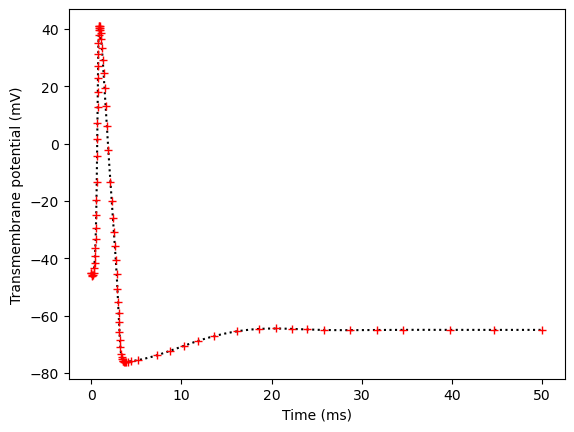

In [26]:
# model
model = HodgkinHuxley()

# settings
u0 = [-45, 0.31, 0.05, 0.59]
t_span = (0, 50)
tol = 0.01

# reference solution
rtol = 1e-10
atol = 1e-12
sol_ref = solve_ivp(model, t_span, u0, rtol=rtol, atol=atol)
t_ref, u_ref = sol_ref.t, sol_ref.y

# TR-BDF2
solver = TR_BDF2_Adaptive(model)
solver.set_initial_condition(u0)

t, u = solver.solve(t_span, tol)

plt.plot(t_ref, u_ref[0, :], 'k:')
plt.plot(t, u[:,0], 'r+')
plt.xlabel("Time (ms)")
plt.ylabel("Transmembrane potential (mV)")
plt.show()

In [27]:
solvers = {'TR-BDF2':[TR_BDF2_Adaptive, 2],
           'RKF45': [RKF45, 4],
           'EulerHeun': [EulerHeun, 1]}

for solver_name, (solver_class, order) in solvers.items():
    solver = solver_class(model)
    solver.set_initial_condition(u0)

    print(f'{solver_name} order = {order}')
    print(f'Tolerance   Global error   Number of steps')
    for tol in [1.0, 0.1, 0.01]:
        t, u = solver.solve(t_span, tol)
        steps = len(t)
        e = abs(u[-1, 0] - u_ref[0, -1])
        print(f'{tol:<8.3f}    {e:<12.7f}   {steps}')

TR-BDF2 order = 2
Tolerance   Global error   Number of steps
1.000       0.0336961      24
0.100       0.0175664      43
0.010       0.0028838      83
RKF45 order = 4
Tolerance   Global error   Number of steps
1.000       0.2653574      169
0.100       0.1428794      114
0.010       0.0054336      123
EulerHeun order = 1
Tolerance   Global error   Number of steps
1.000       0.7790351      158
0.100       0.0016579      220
0.010       0.0014654      432


/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:30: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55.0) / (1.0 - onp.exp(-0.1 * (V + 55.0)))
/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:33: RuntimeWarning: overflow encountered in exp
  return 0.125 * onp.exp(-0.0125 * (V + 65.0))
/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:36: RuntimeWarning: overflow encountered in exp
  return 0.1 * (V + 40.0) / (1.0 - onp.exp(-0.1 * (V + 40.0)))
/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:39: RuntimeWarning: overflow encountered in exp
  return 4.0 * onp.exp(-0.0556 * (V + 65.0))
/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:42: RuntimeWarning: overflow encountered in exp
  return 0.07 * onp.exp(-0.05 * (V + 65.0))
/var/folders/sy/n4jd273x5mv_3q_n6q5w1cqw0000gn/T/ipykernel_8246/1452143735.py:45: RuntimeWarning: overflow 